In [153]:
import netket as nk
import numpy as np

from scipy.sparse.linalg import eigsh

from tqdm import tqdm
from functools import partial

import jax
import jax.numpy as jnp
import jax.experimental.sparse as jsparse

from flax import linen as nn # flax is library that brings a more pytorch-like API to JAX
import optax # optax is a library that provides optimizers and learning rate schedules

import matplotlib.pyplot as plt

In [120]:
# defining the hamiltonian on a 4x4 spin lattice

g = nk.graph.Hypercube(length=4, n_dim=2, pbc=True)
hi = nk.hilbert.Spin(s=1/2, N=g.n_nodes)

# netket already provides a function to create the hamiltonian for the ising model (which is real valued)
h_nk = nk.operator.Ising(hi, g, h=1.0, J=1.0, dtype=float).to_sparse()

# converting the netket operator to a jax sparse matrix in BCSR format
h = jsparse.BCSR.from_scipy_sparse(h_nk)

In [130]:
ground_energies, ground_states = eigsh(h_nk, k=1)
ground_idx = np.argmin(ground_energies)
ground_energy = ground_energies[ground_idx]
ground_state = ground_states[:, ground_idx]

print(f"Ground Energy: {ground_energy:.5f}")

Ground Energy: -34.01060


In [131]:
class Jastrow(nn.Module):
    @nn.compact
    def __call__(self, x):
        n_sites = x.shape[-1]

        J = self.param("J", nn.initializers.normal(), (n_sites,n_sites), float)

        dtype = jnp.promote_types(J.dtype, x.dtype)
        J = J.astype(dtype)
        x = x.astype(dtype)

        J_symm = J.T + J
        log_amplitude = jnp.einsum("...i,ij,...j", x, J_symm, x)

        return log_amplitude

In [178]:
def get_amplitudes(model, params):
    configs = hi.all_states()
    log_psi = model.apply(params, configs)
    psi = jnp.exp(log_psi)
    psi_norm = psi / jnp.linalg.norm(psi)
    return psi_norm


def get_energy(model, params, h):
    psi = get_amplitudes(model, params)
    h_exp = psi.conj().T@(h@psi)
    return h_exp


@partial(jax.jit, static_argnames='model')
def get_energy_grad(model, params, h):
    energy_grad_fun = jax.value_and_grad(get_energy, argnums=1)
    energy, energy_grad = energy_grad_fun(model, params, h)
    return energy, energy_grad

In [180]:
model = Jastrow()
params = model.init(jax.random.key(0), np.ones((hi.size, )))
logger = nk.logging.RuntimeLog()

for i in tqdm(range(180)):
    energy, gradient = get_energy_grad(model, params, h)
    params = jax.tree.map(lambda p, g: p - 0.01 * g, params, gradient)
    logger(step=i, item={'Energy': energy})

100%|██████████| 180/180 [00:03<00:00, 47.61it/s]


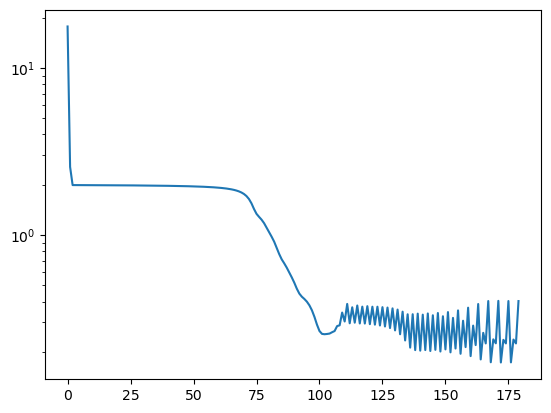

In [181]:
plt.figure()
# we use the ground state energy to push the energies into the positive regime
plt.semilogy(logger.data['Energy']['iters'], np.abs(logger.data['Energy']['value'] - ground_energy))
plt.show()

In [233]:
# Initialize model and optimizer
model = Jastrow()
params = model.init(jax.random.key(0), np.ones((hi.size, )))

# Learning rate schedule
lr_schedule = optax.exponential_decay(init_value=0.01, transition_steps=50, decay_rate=0.9)
optimizer = optax.adam(learning_rate=lr_schedule)
opt_state = optimizer.init(params)

logger = nk.logging.RuntimeLog()

# Optimization loop
for i in tqdm(range(300)):
    energy, grads = get_energy_grad(model, params, h)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    logger(step=i, item={'Energy': energy})

100%|██████████| 300/300 [00:06<00:00, 46.01it/s]


In [235]:
# final energy
final_energy = get_energy(model, params, h)
print(f"Final Energy: {final_energy:.5f}")

Final Energy: -33.97007


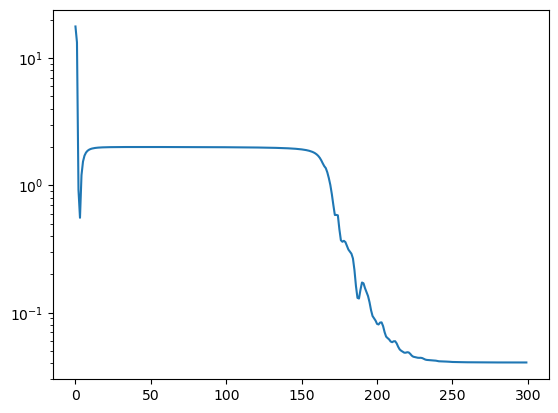

In [234]:
plt.figure()
# we use the ground state energy to push the energies into the positive regime
plt.semilogy(logger.data['Energy']['iters'], np.abs(logger.data['Energy']['value'] - ground_energy))
plt.show()

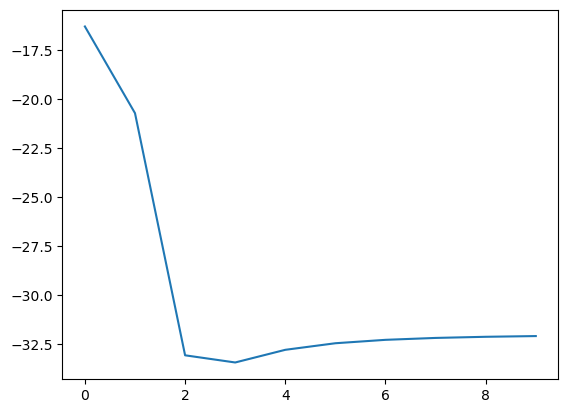

In [239]:
# print only the first 10 epochs

plt.figure()
plt.plot(logger.data['Energy']['iters'][:10], logger.data['Energy']['value'][:10])
plt.show()

In [378]:
import jax
import jax.numpy as jnp
import optax
import netket as nk
from tqdm import tqdm

# Initialize model
model = Jastrow()

# we know that the couplings are somewhere around +-0.02. We initialize by some normal enveloping them
key, subkey = jax.random.split(jax.random.PRNGKey(0))
params = model.init(key, 0.02 * jax.random.normal(subkey, shape=(hi.size,)))

# Learning rate schedule
lr_schedule = optax.exponential_decay(init_value=0.01, transition_steps=50, decay_rate=0.9)

# AdamW Optimizer (Adam + Weight Decay)
optimizer = optax.adamw(learning_rate=lr_schedule, weight_decay=1e-4, b1=0.6, b2=0.99)



# Initialize optimizer state
opt_state = optimizer.init(params)
logger = nk.logging.RuntimeLog()

# Optimization loop
for i in tqdm(range(100)):
    energy, grads = get_energy_grad(model, params, h)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    logger(step=i, item={'Energy': energy})

100%|██████████| 100/100 [00:02<00:00, 46.02it/s]


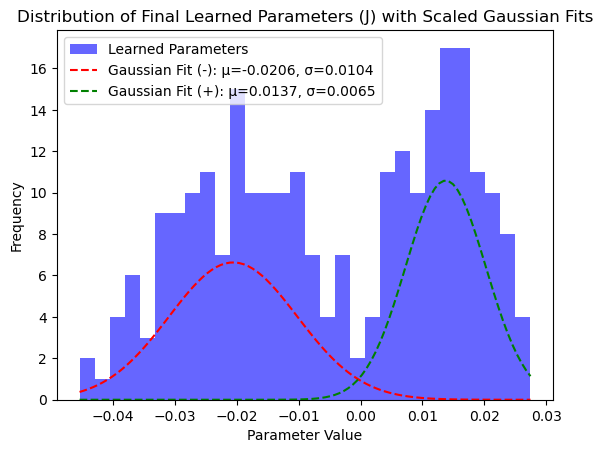

In [379]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import jax.numpy as jnp

# Flatten the parameter array
params_flat = jnp.array(params["params"]["J"]).flatten()

# Fit two Gaussian distributions
mean1, std1 = norm.fit(params_flat[params_flat < 0])  # Fit for negative values
mean2, std2 = norm.fit(params_flat[params_flat > 0])  # Fit for positive values

# Generate x-values for the Gaussians
x = np.linspace(params_flat.min(), params_flat.max(), 100)

# Compute histogram for scaling
hist_values, bin_edges = np.histogram(params_flat, bins=30, density=False)
bin_width = bin_edges[1] - bin_edges[0]
scaling_factor = max(hist_values) / max(max(norm.pdf(x, mean1, std1)), max(norm.pdf(x, mean2, std2)))

# Scale Gaussians to fit histogram
gauss1 = norm.pdf(x, mean1, std1) * scaling_factor * bin_width * len(params_flat)
gauss2 = norm.pdf(x, mean2, std2) * scaling_factor * bin_width * len(params_flat)

# Plot histogram
plt.hist(params_flat, bins=30, alpha=0.6, color='b', density=False, label="Learned Parameters")

# Plot the two Gaussian curves
plt.plot(x, gauss1, 'r--', label=f"Gaussian Fit (-): \u03bc={mean1:.4f}, \u03c3={std1:.4f}")
plt.plot(x, gauss2, 'g--', label=f"Gaussian Fit (+): \u03bc={mean2:.4f}, \u03c3={std2:.4f}")

# Labels and legend
plt.xlabel("Parameter Value")
plt.ylabel("Frequency")
plt.title("Distribution of Final Learned Parameters (J) with Scaled Gaussian Fits")
plt.legend()
plt.show()


In [380]:
# final energy
final_energy = get_energy(model, params, h)
print(f"Final Energy: {final_energy:.5f}")

Final Energy: -33.96986


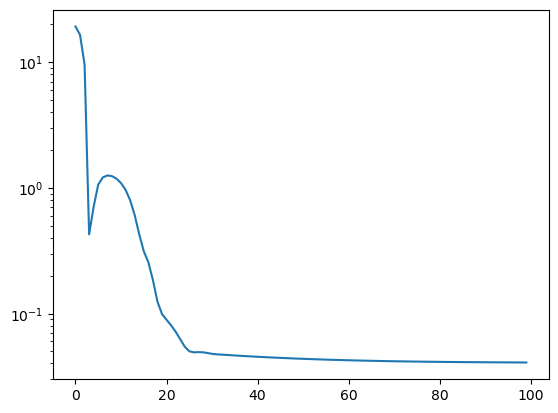

In [381]:
plt.figure()
# we use the ground state energy to push the energies into the positive regime
plt.semilogy(logger.data['Energy']['iters'], np.abs(logger.data['Energy']['value'] - ground_energy))
plt.show()